In [1]:
### Amazon Fine Food Reviews 

# Data Source :: https://www.kaggle.com/snap/amazon-fine-food-reviews

## Data Contains reviews of Food products from Amazon.com. Reviews include User info, ratings (polarity), and text comments. 

# Perform dimensionality reduction using T-SNE along with NLP techniques like BOW, Tf-Idf, W2Vec, AvgWord2Vec etc.

# Data includes : 
    # Reviews from Oct 1999 - Oct 2012
    # 568,454 reviews
    # 256,059 users
    # 74,258 products
    # 260 users with > 50 reviews
    
## Attribute/Feature Information 
    # Id
    # ProductId - Uniques id of the product
    # UserId - unqiue identifier for the user
    # ProfileName
    # HelpfulnessNumerator - number of users who found the review helpful
    # HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    # Score - rating between 1 and 5
    # Time - timestamp for the review
    # Summary - brief summary of the review
    # Text - text of the review

### OBJECTIVE: Determine Polarity 
    # Given a review, determine the review is positive or negative
    # Analyze summary and text of the given review using NLP techniques and determine whether feedback is 
        # posiive or negative

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import gensim
import random
import warnings

warnings.filterwarnings("ignore")  ## To filter warnings 

%matplotlib inline 



C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
### As a first step lets perform EDA: Exploratory Data Analysis

# Load Data using sqilte connection

con = sql.connect('database.sqlite')

df = pd.read_sql_query(''' SELECT * from Reviews''', con)

# Reviews is the name of the table
# Reviews with score == 3 is ignroed, assuming it indicates that of no Polarity (Neither positive not negative)

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
print (df.describe())

print (df.shape)
print (df['Score'].shape)

                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.351210e+09  
(568454, 10)
(568454,)


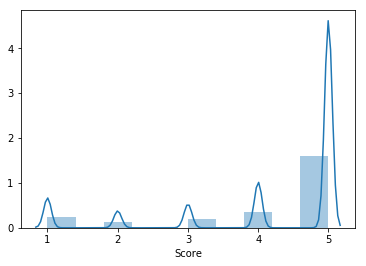

In [5]:
sns.distplot(df['Score'], bins=10)
plt.show()

In [6]:
## We can see that its un balanced dataset with review 5 more counts

df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [7]:
## Let us remove score == 3 , as said it is neither positive nor negative review

df = pd.read_sql_query(''' SELECT * from Reviews WHERE SCORE != 3 ''', con)

In [8]:
## Here Score is the Output Feature (y), Lets convert it into Positive/Negative instead of numbers 

def polarity(x):
    if x < 3:
        return 'Negative'
    else :
        return 'Positive'

df.Score = df.Score.map(polarity)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
### Data Cleaning: 
    # Lets do some data cleaning tasks on our data set
    
# 1. There are some duplicated reviews, wherein different products Reviewed by same User at Same Time. Which is not Possible
# This happened because Amazon replicated User review to same kind of product with different color/flavour etc.. 

### For Example .. Display one record by a user 

display = pd.read_sql_query(''' SELECT * from Reviews WHERE Score != 3 and USERID = "AR5J8UI46CURR" ORDER BY PRODUCTID''', con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [10]:
## From above execution, we can understand that User hase reviewd multiple products at same time. Whichc is not possible

## Let us delete reviews which are duplicated 

df1 = df.drop_duplicates(subset={'UserId', "ProfileName", "Time", "Text"}, keep="first")

## No . of rows after deleting duplicates 
df1.Id.size

364173

In [11]:
## Total No.Of rows reduced from 568454 to 3641730 

### Let us also work on HelpFulness Numerator/Denominator
## Helpfulness Denominator should be always equal or greater than Numerator
# Remove if Helpfullness numerator is greater than Denominator

df2 = df1[df1.HelpfulnessNumerator <= df1.HelpfulnessDenominator]
df2.Id.size

364171

In [12]:
## Now Its all set with Duplicated Data 

### Lets Do Some TEXT Processing 
    # HTML Tag removal
    
import re 

def stripHTML(text):
    ''' This method strips content in between HTML tags in the given text
    
    text: Text data
    return: Data
    '''
    var = re.compile ('<.*?>') ## Find for a pattern <html>
    return var.sub('', text) # Substitute blank at matched string

## For Example 
stripHTML("<HTML>Hello Yashwanth!!</HTML>")

'Hello Yashwanth!!'

In [13]:
## Punctuations Removal (?, !, #, /, etc.. )

def stripPunctuation(text):
    ''' This method strips Punctuations in the given text
    
    text: Text data
    return: Data
    '''
    var = re.compile (r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]') ## Find for Punctuations 
    return var.sub('', text) # Substitute blank at matched string

## For Example 
stripPunctuation("Hello Yashwanth!! How are you ?")

'Hello Yashwanth How are you '

In [14]:
### Now Lets Work On StopWords 

# Stopwords are most common used words in english like is, was, are, had etc

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = stopwords.words('english')

## Excluding some use ful words as we see them in some of our reviews.

excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

In [15]:
## Breif notes on Stemmer (PorterStemmer and SnowballStemmer)

## Stemming reduces a word to its root/stem word. The result is less readable by humnans, 
    # but useful in text processing

## Porter Stemmer: Most commonly used stemmer without a doubt, also one of the most gentle stemmers. 
    # Though it is also the most computationally intensive of the algorithms. 
    # It is also the oldest stemming algorithm by a large margin.

## SnowBall Stemmer(Porter2): Nearly universally regarded as an improvement over porter, and for good reason.
    # Porter himself in fact admits that it is better than his original algorithm. 
    # Slightly faster computation time than Porter, with a fairly large community around it.
    
## Example Words 


from nltk.stem import SnowballStemmer

snow = SnowballStemmer('english') #initialising the snowball stemmer

print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))
print(snow.stem('amaze'))
print(snow.stem('initialize'))
print(snow.stem('fabulous'))
print(snow.stem('Honda City'))
print(snow.stem('unpleasant'))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici
amaz
amaz
initi
fabul
honda c
unpleas


In [16]:
### Differences between Stemming and Lemmatization 

## Both Stemming and Lemmatization attempt to bring a canonical form for a set of related word forms. 
## Lemmatization takes the part of speech into consideration.
    # For Ex. the word 'meeting' may be returned as 'meeting' or as 'meet'.
## Lemmatizatiobn uses tagged vocabulary (such as wordnet) and can perform more sophisticated normalization.
    # Ex. mice transformed to Mouse or mice and foci to focus
## A stem produced by typical stemmers may not be a word that is part of language vocabulary but Lemmatization
    # transforms the given word into valid lemma

In [17]:
%%time


## For Example: LETS PERFORM PREPROCESSING ON ONE REVIEW

str1 = ''
final_string=[]
all_positive_words = []
all_negative_words=[]
s = ''

for var in df2['Text'][2:3].values: ## RUnning for 2 review
    filtered_senternce = []
    print (var)
    var = stripHTML(var)
    var = stripPunctuation(var)
    print (var.split())
    
    for word in var.split():
        if word.isalpha() and len(word) > 2: ## if numerical value or char length greater than 2
            if (word.lower() not in stop): # if  it is stop word
                s = (snow.stem(word.lower())).encode('utf8') ## Stemming word using Snowball stemmer
                filtered_senternce.append(s)
            else :
                print ("word Eliminated as it is stop word")
                continue
        else :
            print ("Eliminated as it is Numerical Value or Length less than 2 char")
    
    str1 = b' '.join(filtered_senternce)  ## Final String of clean Words after Stemming
    final_string.append(str1)
    
    print ("Final selected words from review:\n ", final_string)

This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.
['This', 'is', 'a', 'confection', 'that', 'has', 'been', 'around', 'a', 'few', 'centuries', 'It', 'is', 'a', 'light', 'pillowy', 'citrus', 'gelatin', 'with', 'nuts', '-', 'in', 'this', 'case', 'Filberts', 'And', 'it', 'is', 'cut', 'into', 'tiny', 'squares', 'and', 'then', 'liberally', 'coated', 'with', 'powdered', 'sugar', 'And', 'it', 'is', 'a', 'tiny', 'mouthful', 'of', 'heaven', 'Not', 'too', 'chewy', 'and', 'very', 'flavorful', 'I', 'highly', 'recommend', 'this', 'yummy', 'treat', 

In [18]:
%%time
#### Now LETS PROCESS ON ALL REVIEWS .. TAKES more time to run this 

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
t0=time()

for var in df2['Text'].values:
    filtered_sentence=[]
    
    var=stripHTML(var) # remove HTMl tags
    var=stripPunctuation(var) # remove Punctuation Symbols

    for w in var.split():
        if((w.isalpha()) and (len(w)>2)): #If it is a numerical value or character of length greater than 2    
            if(w.lower() not in stop): # If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                                        #encoding as byte-string/utf-8

                filtered_sentence.append(s)
                if (df2['Score'].values)[i] == 'Positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(df2['Score'].values)[i] == 'Negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i += 1

print ("Processing Completed")

Processing Completed
Wall time: 7min


In [19]:
%%time

### Cleaned Text without Stemming for google trained Word2Vec 

i=0
str1=' '
final_string_nostem=[]
s=''
t0=time()
for sent in df2['Text'].values:
    filtered_sentence=[]
    sent=stripHTML(sent)# remove HTMl tags
    sent=stripPunctuation(sent)# remove Punctuation Symbols
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=w.lower().encode('utf8') #encoding as byte-string/utf-8
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence)
    final_string_nostem.append(str1)
    i += 1
    
print ("Preprocessing Finished in ")

Preprocessing Finished in 
Wall time: 1min 1s


In [20]:
### Separate Positive and Negative Words reviews 

from collections import Counter

print("No. of positive words:",len(all_positive_words))
print("No. of negative words:",len(all_negative_words))

# print("Sample postive words",all_positive_words[:9])
# print("Sample negative words",all_negative_words[:9])

positive = Counter(all_positive_words)
print("\nMost Common postive words",positive.most_common(10))

negative = Counter(all_negative_words)
print("\nMost Common negative words",negative.most_common(10))

No. of positive words: 11678044
No. of negative words: 2393854

Most Common postive words [(b'not', 145019), (b'like', 138335), (b'tast', 126024), (b'good', 109838), (b'love', 106551), (b'flavor', 106408), (b'use', 102872), (b'great', 101125), (b'one', 94396), (b'product', 88466)]

Most Common negative words [(b'not', 53634), (b'tast', 33828), (b'like', 32059), (b'product', 27411), (b'one', 20176), (b'flavor', 18898), (b'would', 17858), (b'tri', 17515), (b'use', 15148), (b'good', 14616)]


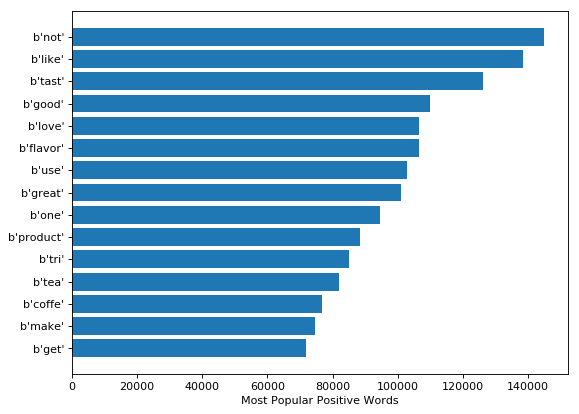

In [21]:
#### Positive Words Graph 

from matplotlib.pyplot import figure 

figure (num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')

pos_words = positive.most_common(15)

pos_words.sort(key=lambda x : x[1], reverse=False)

words=[]
times=[]

for w,t in pos_words:
    words.append(w)
    times.append(t)
    
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Positive Words')
plt.show()

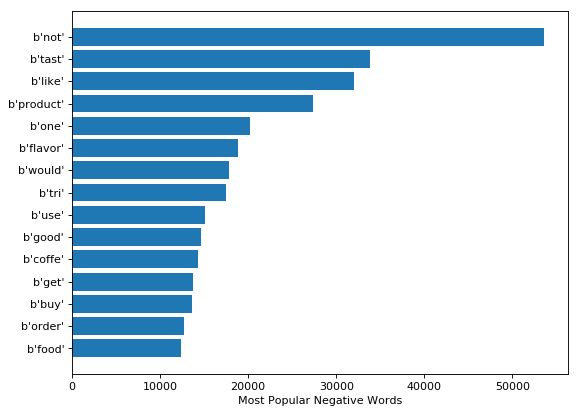

In [22]:
neg_words = negative.most_common(15)

neg_words.sort(key=lambda x: x[1], reverse=False) 
words=[]
times=[]

for w,t in neg_words:
    words.append(w)
    times.append(t)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.barh(range(len(words)),times)
plt.yticks(range(len(words)),words) 
plt.xlabel('Most Popular Negative Words')
plt.show()

In [23]:
### Let us store Preprocessed data bact to DB

df2['CleanedText'] = final_string
df2['CleanedText_NoStem'] = final_string_nostem
df2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b''
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b''


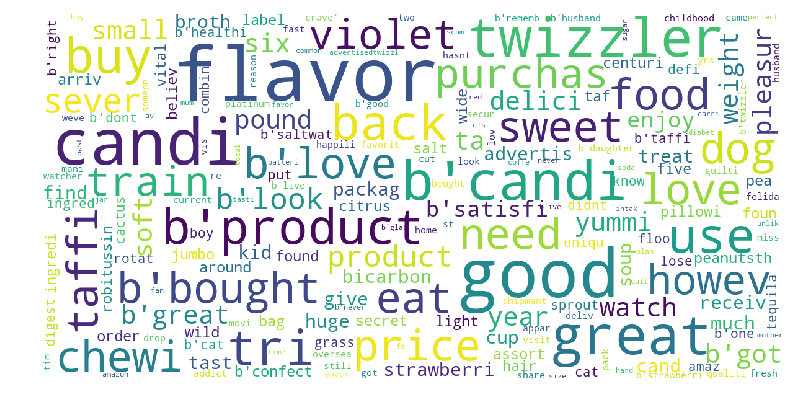

In [24]:
################################################## 
## Simple Fun Execrise of wordcloud of whole dataset 

from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

plt.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 

def display_wordcloud(data, title=None):
    ''' Let us perform wordcloud on whole dataset'''
    wordcloud = WordCloud(background_color='white', 
                         stopwords=stopwords, max_words=200,
                         max_font_size=40, scale=3, 
                         random_state=1).generate(str(data))
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    
    if title:
        fig.subtitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    
    plt.imshow(wordcloud)
    plt.show()
    
display_wordcloud(df2.CleanedText)
#df2.loc[df2['Score'] == 'Positive']['CleanedText']

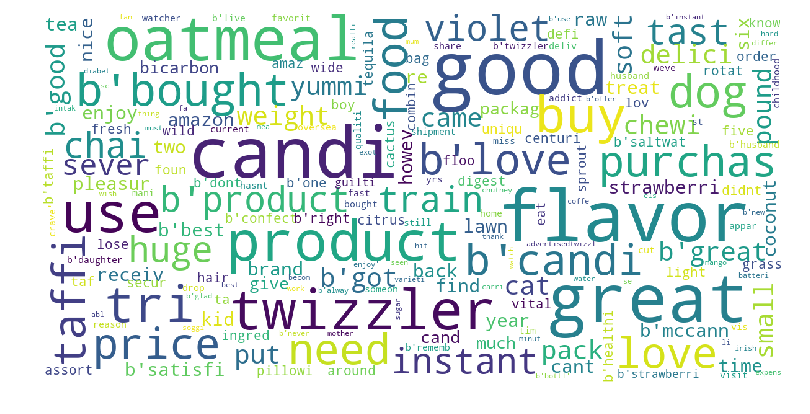

In [25]:
## Word Cloud on Positive Data set 

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

plt.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df2.loc[df2['Score'] == 'Positive']['CleanedText'])

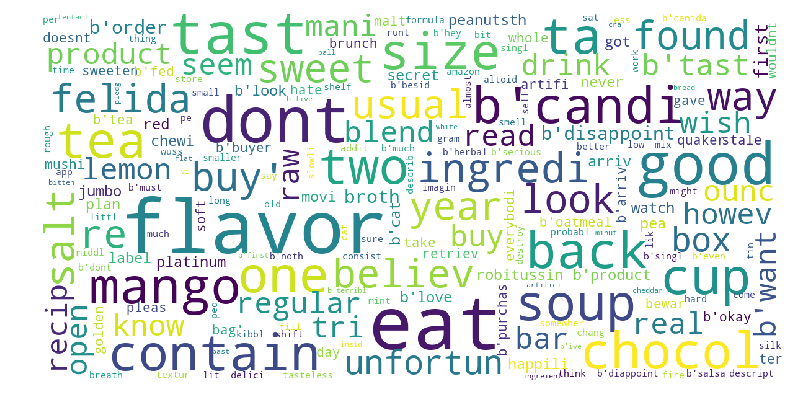

In [26]:
### Word cloud on Negative Reviews 

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

plt.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df2.loc[df2['Score'] == 'Negative']['CleanedText'])

In [27]:
### Storing dataframe in sqlite3

import sqlite3

con = sqlite3.connect('final.sqlite')
con.text_factory = str ## To Store Strings as byte strings
df2.to_sql('Reviews', con, if_exists='replace')


In [28]:
## Using sqlite3 to retrieve data from sqlite file

con = sql.connect('final.sqlite')

df2= pd.read_sql_query(''' SELECT * from Reviews''', con)

In [29]:
################################################################################################
################################################################################################
################################################################################################
################################################################################################
################################################################################################

## START BIG PICTURE -- WAYS TO CONVERT TEXT to VECTOR 

## BOW - Bag Of Words 

# 1. Unigram BOW 

from sklearn.feature_extraction.text import CountVectorizer


In [30]:
%%time

uni_gram = CountVectorizer()
uni_gram_vectors = uni_gram.fit_transform(df2.CleanedText.values)

Wall time: 14.8 s


In [31]:
## Let us write some function to save objects in a file

import pickle 

def savetofile(obj, filename):
    pickle.dump(obj, open(filename+".p","wb"), protocol=4)

def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [32]:
## save Uniugram to file 

savetofile(uni_gram_vectors, 'uni_gram')

## Loading from file for simple testing 

uni_gram_vectors = openfromfile('uni_gram')

uni_gram_vectors.shape[1]

209129

In [33]:
type (uni_gram_vectors)

scipy.sparse.csr.csr_matrix

In [34]:
%%time

from sklearn.decomposition import TruncatedSVD

tsvd_uni = TruncatedSVD(n_components=100) # No of components == Total Dimensions 
tsvd_uni_vec = tsvd_uni.fit_transform(uni_gram_vectors)

Wall time: 1min 4s


In [35]:
savetofile(tsvd_uni, "tsvd_uni")
savetofile(tsvd_uni_vec, "tsvd_uni_vec")

In [36]:
tsvd_uni = openfromfile('tsvd_uni')
tsvd_uni_vec = openfromfile('tsvd_uni_vec')

In [37]:
tsvd_uni.explained_variance_ratio_[:].sum()

0.42466838329353185

In [38]:
%%time
#########################################################################
#########################################################################

## Lets Perform TSNE on dataset 

from sklearn.manifold import TSNE
from time import time 
import random

n_samples = 2000

sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]

sample_class = df2['Score'][sample_cols]
sample_class = sample_class [:, np.newaxis]

print (sample_features.shape, sample_class.shape)

model = TSNE (n_components=2, random_state=0, perplexity=30)

t0 = time()

embedded_data = model.fit_transform(sample_features)

print ("TSNE Done in ", time() - t0)

final_data = np.concatenate((embedded_data, sample_class), axis=1)
print (final_data.shape)

newdf = pd.DataFrame(data=final_data, columns=['Dim1', 'Dim2', 'Class'])


(2000, 100) (2000, 1)
TSNE Done in  25.195111751556396
(2000, 3)
Wall time: 26.3 s


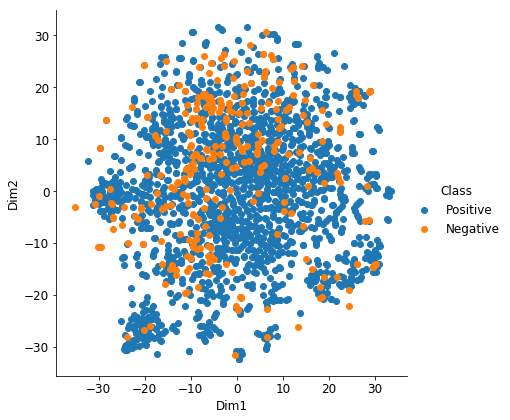

In [39]:
## PLot TSNE with perplexity == 30
sns.FacetGrid(newdf, hue="Class", size=6).map(plt.scatter, "Dim1", "Dim2").add_legend()
plt.show()

TSNE done in  27.475361108779907


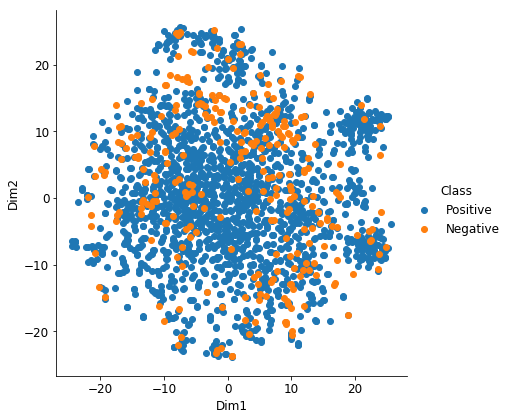

In [40]:
### build model with perplexity = 40

model = TSNE(n_components=2, random_state=0, perplexity=40)
t0 = time()
embedded_data = model.fit_transform(sample_features)

print ("TSNE done in ", time() - t0)

final_data = np.concatenate((embedded_data, sample_class), axis=1)
newdf = pd.DataFrame(data=final_data, columns=['Dim1', 'Dim2', 'Class'])

sns.FacetGrid(newdf, hue='Class', size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()


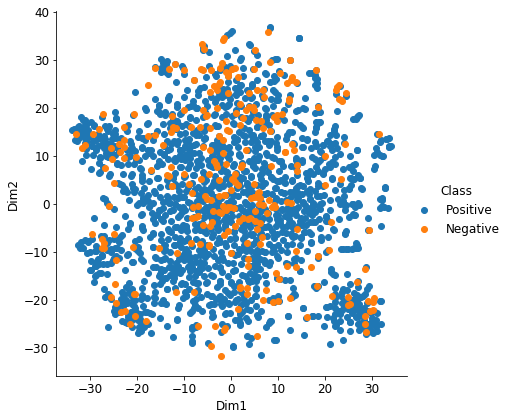

In [41]:
#### Lets Perform with 10K points and perplexity = 30

n_samples = 2000

sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]

sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:, np.newaxis]

model = TSNE(n_components=2, random_state=0, perplexity=30)

embedded_data = model.fit_transform(sample_features)

final_data = np.concatenate((embedded_data, sample_class), axis=1)

newdf = pd.DataFrame(data=final_data, columns=['Dim1', 'Dim2', 'Class'])

sns.FacetGrid(newdf, hue='Class', size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [42]:
%%time
#########################################################################################
#########################################################################################
#########################################################################################

### BOW -- Bag Of Words -- Bi Gram 

bi_gram = CountVectorizer(ngram_range=(1, 2))
bi_gram_vectors = bi_gram.fit_transform(df2.CleanedText.values)

Wall time: 53.8 s


In [43]:
savetofile(bi_gram_vectors, "bi_gram")

In [44]:
bi_gram_vectors = openfromfile('bi_gram')

print (bi_gram_vectors.shape)
type(bi_gram_vectors)

(364171, 3404647)


scipy.sparse.csr.csr_matrix

In [45]:
print ('Bi grams are more iin length than unigrams by ', ((bi_gram_vectors.shape[1]/uni_gram_vectors.shape[1])))

Bi grams are more iin length than unigrams by  16.28012853310636


In [46]:
%%time 

sample_points = df2.sample(20000)

bi_gram_vectors = bi_gram.fit_transform(sample_points['CleanedText'])

tsvd_bi = TruncatedSVD(n_components=100)
tsvd_bi_vec = tsvd_bi.fit_transform(bi_gram_vectors)


savetofile(tsvd_bi,"tsvd_bi")
savetofile(tsvd_bi_vec,"tsvd_bi_vec")

tsvd_bi = openfromfile("tsvd_bi")
tsvd_bi_vec = openfromfile("tsvd_bi_vec")


tsvd_bi.explained_variance_ratio_[:].sum()

Wall time: 28.5 s


(2000, 100) (2000, 1)
TSNE done in  27.284921169281006
(2000, 3)


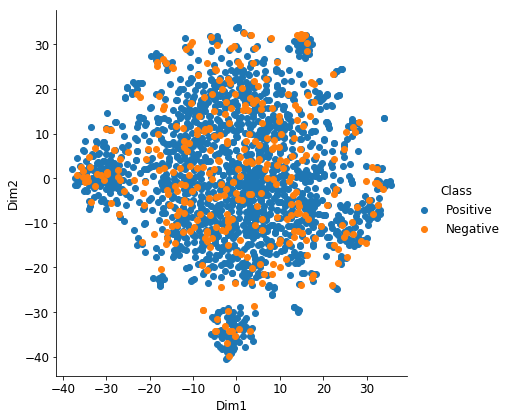

Wall time: 27.7 s


In [47]:
%%time
### TSNE bi_gram with 2k points and perplexity = 30

n_samples = 2000

sample_cols = random.sample(range(1, tsvd_bi_vec.shape[0]), n_samples)
sample_features = tsvd_bi_vec[sample_cols]

sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]

print(sample_features.shape,sample_class.shape)

model = TSNE(n_components=2,random_state=0,perplexity=30)

t0 = time()
embedded_data = model.fit_transform(sample_features)

print("TSNE done in ", time() - t0)

# print(embedded_data.shape,sample_class.shape)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
print(final_data.shape)

newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])

sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

In [48]:
#################################################################################
#################################################################################
#################################################################################


### TF-IDF 
# TF = Term Frequecny, IDF = Inverse Document Frequency 


In [49]:
%%time 

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2)) ## Using Bigram
tfidf_vec = tfidf.fit_transform(df2['CleanedText'])

Wall time: 1min 8s


In [50]:
#Saving the variable to access later without recomputing
savetofile(tfidf_vec,"tfidf")

#Loading the variable from file
tfidf_vec = openfromfile("tfidf")

print (tfidf_vec.shape)

print(tfidf_vec[2])

(364171, 3404647)
  (0, 1995684)	0.02305776200007636
  (0, 634637)	0.09629761366557359
  (0, 148485)	0.049162135767580314
  (0, 483299)	0.09513083522197018
  (0, 1680739)	0.05112544957320399
  (0, 2212861)	0.1316315007551852
  (0, 556420)	0.07819345486266117
  (0, 1232676)	0.08658635260193757
  (0, 2018759)	0.05537554112134045
  (0, 465022)	0.050651859150299176
  (0, 1093493)	0.11960166962240944
  (0, 737841)	0.0569454130210765
  (0, 3064216)	0.1285583007148875
  (0, 2798119)	0.07419995552116052
  (0, 1673827)	0.09607634675615005
  (0, 575573)	0.061353669843406504
  (0, 2271789)	0.054298203777919975
  (0, 2885378)	0.0416697262505671
  (0, 1920053)	0.056256116258594495
  (0, 1397444)	0.0704243632010098
  (0, 516953)	0.060604862352701704
  (0, 1125576)	0.0279279616420308
  (0, 1414824)	0.040096342878000096
  (0, 2423531)	0.03774425986148984
  (0, 3396938)	0.057116989212847885
  :	:
  (0, 576437)	0.13296710965216912
  (0, 2273524)	0.09362294825085767
  (0, 2888619)	0.12662130763497767
  (

In [51]:
features = tfidf.get_feature_names()
features[19000:19010]

['actual scorpion',
 'actual scottish',
 'actual scrape',
 'actual scratch',
 'actual scream',
 'actual screw',
 'actual scrub',
 'actual seafood',
 'actual seal',
 'actual sear']

In [ ]:
from sklearn.decomposition import TruncatedSVD

tsvd_tfidf = TruncatedSVD(n_components=100)#No of components as total dimensions
tsvd_tfidf_vec = tsvd_tfidf.fit_transform(tfidf_vec)

savetofile(tsvd_tfidf,"tsvd_tfidf")
savetofile(tsvd_tfidf_vec,"tsvd_tfidf_vec")


tsvd_tfidf_vec = openfromfile("tsvd_tfidf_vec")
tsvd_tfidf = openfromfile("tsvd_tfidf")


tsvd_tfidf.explained_variance_ratio_[:].sum()

In [ ]:
%%time

## Perplexity 20 with 10K points 

from sklearn.manifold import TSNE
from time import time
import random

n_samples = 2000

sample_cols = random.sample(range(1, tsvd_tfidf_vec.shape[0]), n_samples)
sample_features = tsvd_tfidf_vec[sample_cols]

sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]

print(sample_features.shape,sample_class.shape)

model = TSNE(n_components=2,random_state=0,perplexity=20)

t0 = time()
embedded_data = model.fit_transform(sample_features)
print("TSNE done in  ", time() - t0) 

final_data = np.concatenate((embedded_data,sample_class),axis=1)

print(final_data.shape)

newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])

sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

In [ ]:
%%time

## Perplexity 40 with 2k points 

sample_cols = random.sample(range(1, tsvd_tfidf_vec.shape[0]), n_samples)
sample_features = tsvd_tfidf_vec[sample_cols]

sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]

print(sample_features.shape,sample_class.shape)
model = TSNE(n_components=2,random_state=0,perplexity=40)

# print(sample_features,sample_class)

t0 = time()
embedded_data = model.fit_transform(sample_features)

print("TSNE done in ", time() - t0)

final_data = np.concatenate((embedded_data,sample_class),axis=1)

print(final_data.shape)

newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])

sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

In [ ]:
#########################################################################
#########################################################################
#########################################################################


### Word2Vec using Gensim

final_string = []
for sent in df2['CleanedText'].values:
    sent = str(sent)
    sentence=[]
#     print(sent)
    for word in sent.split():
#         print(word)
        sentence.append(word)
#         print(sentence)
    final_string.append(sentence)

In [ ]:
%%time 


## train your word2vec model using your own text corpus 
import gensim

w2v_model=gensim.models.Word2Vec(final_string,min_count=5,size=50, workers=-1)

w2v_model.save('w2vmodel')  ## Saving Model 

w2v_model = gensim.models.Word2Vec.load('w2vmodel') ## Load model 

w2v_vocub = w2v_model.wv.vocab
print (len(w2v_vocub))


In [ ]:
w2v_model.wv.most_similar('tast')

In [ ]:
w2v_model.wv.most_similar('food')

In [ ]:
#################################################################
#################################################################

### Avg Word2Vec 

%%time

np.seterr(divide='ignore', invalid='ignore')
avg_vec = [] #List to store all the avg w2vec's 
for sent in final_string:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(50) #Initializing with zeroes
    
    for word in sent:
        try:
            wvec = w2v_model.wv[word] #Vector of each using w2v model
            sent_vec += wvec #Adding the vectors 
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing 
    
    a_vec =sent_vec / cnt #Taking average of vectors sum of the particular review
    avg_vec.append(a_vec) #Storing the avg w2vec's for each review
    

In [ ]:
#Saving the variable to access later without recomputing
savetofile(avg_vec,"avg_w2v_vec")

In [ ]:

#Loading the variable from file
avg_vec = openfromfile("avg_w2v_vec")

In [ ]:

avg_vec = np.array(avg_vec)
avg_vec.shape

In [ ]:
## Normalizing 

from sklearn import preprocessing
avg_vec_norm = preprocessing.normalize(avg_vec)

In [ ]:
%%time
from sklearn.manifold import TSNE
from time import time
import random

n_samples = 5000

sample_cols = random.sample(range(1, avg_vec.shape[0]), n_samples)
sample_features = avg_vec[sample_cols]


sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
print(sample_features.shape,sample_class.shape)

model = TSNE(n_components=2,random_state=0,perplexity=30)

embedded_data = model.fit_transform(sample_features)

final_data = np.concatenate((embedded_data,sample_class),axis=1)

print(final_data.shape)
newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])

sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

In [ ]:
%%time


n_samples = 10000

sample_cols = random.sample(range(1, avg_vec.shape[0]), n_samples)
sample_features = avg_vec[sample_cols]


# sample_features = df
sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]

print(sample_features.shape,sample_class.shape)
model = TSNE(n_components=2,random_state=0,perplexity=40)

embedded_data = model.fit_transform(sample_features)

# print(embedded_data.shape,sample_class.shape)

final_data = np.concatenate((embedded_data,sample_class),axis=1)
print(final_data.shape)

newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])

sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

In [ ]:
########################################################################################
########################################################################################
########################################################################################


## TFIDF Word2Vec 
# Another way of converting sentence into vector



In [ ]:

#Taking Sample of 20k points
no_datapoints = 364170
sample_cols = random.sample(range(1, no_datapoints), 20001)


In [ ]:
%%time

###tf-idf with No Stemming

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
tfidf_vec_ns = tfidf.fit_transform(df2['CleanedText'].values[sample_cols])

#Saving the variable to access later without recomputing
# savetofile(tfidf_vec,"tfidf")

#Loading the variable from file
# tfidf_vec = openfromfile("tfidf")

print(tfidf_vec_ns.shape)

# tf-idf came up with 2.9 million features for the data corpus
from sklearn.decomposition import TruncatedSVD

tsvd_tfidf_ns = TruncatedSVD(n_components=100)#No of components as total dimensions
tsvd_tfidf_vec_ns = tsvd_tfidf_ns.fit_transform(tfidf_vec_ns)

print(tsvd_tfidf_ns.explained_variance_ratio_[:].sum())
features = tfidf.get_feature_names()

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
import gensim

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
print (STOPWORDS)

In [ ]:
import textblob